## Encoder-Decoder with Attention

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

from data_loader import FlickrDataset, get_loader


In [2]:

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        #resnet = models.resnet101(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features

In [3]:

class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        self.A = nn.Linear(attention_dim,1)
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha, attention_weights
        

In [4]:
class Decoder(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        start_label = vocab.start_label
        end_label = vocab.end_label
        
        #starting input
        word = torch.tensor(vocab.word_to_idx[start_label]).view(1,-1).to(device)
        embeds = self.embedding(word)

        alphas = []
        captions = []
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.idx_to_word[predicted_word_idx.item()] == end_label:
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.idx_to_word[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

In [5]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [19]:
class ModelSaver():
    """
    Stores and loads model, criterion and optimizer
    """
    def __init__(self):
        # Initialize settigns
        
        self.file_name=None
        #hyper params
        self.embed_size = None
        self.vocab_size = None
        self.attention_dim = None
        self.encoder_dim = None
        self.decoder_dim = None
        self.learning_rate = None
        # todo learning rate decay?
        self.pad_idx = None
        self.epoch = None
        
        self.train_loss = []
        self.val_loss = []
            
    def initialize(self,
                 file_name,
                 device,
                 embed_size,
                 vocab_size,
                 attention_dim,
                 encoder_dim,
                 decoder_dim,
                 learning_rate,
                 #epoch=0,
                 pad_idx=0):
        
        if len(file_name) > 4 and file_name[-4:] == '.pth':
            self.file_name = file_name
        else:
            self.file_name = file_name + '.pth'
        #hyper params
        self.embed_size = embed_size
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.learning_rate = learning_rate
        # todo learning rate decay?
        
        self.pad_idx = pad_idx
        
        self.epoch = 0
        
        model = self.__get_model(device)
        criterion = self.__get_criterion()
        optimizer = self.__get_optimizer(model)
        
        return model, criterion, optimizer
        
    def load(self, file_name, device):
        
        model_settings = torch.load(file_name)
        
        self.file_name = file_name
        self.embed_size = model_settings['embed_size']
        self.vocab_size = model_settings['vocab_size']
        self.attention_dim = model_settings['attention_dim']
        self.encoder_dim = model_settings['encoder_dim']
        self.decoder_dim = model_settings['decoder_dim']
        self.learning_rate = model_settings['learning_rate']
        self.pad_idx = model_settings['pad_idx']
        self.epoch = model_settings['epoch']
        
        self.train_loss = model_settings['train_loss']
        self.val_loss = model_settings['val_loss']
        
        model = self.__get_model(device)
        model.load_state_dict(model_settings['state_dict'])
        
        criterion = self.__get_criterion()
        optimizer = self.__get_optimizer(model)
        
        return model, criterion, optimizer
        
    def save(self, state_dict, train_loss=None, val_loss=None):
        """
        updates state_dict
        increase epoch by 1
        """
        self.epoch += 1
        self.train_loss.append(train_loss)
        self.val_loss.append(val_loss)
        
        model_state = {
            'epoch':self.epoch,
            'state_dict':state_dict,
            
            'embed_size':self.embed_size,
            'vocab_size':self.vocab_size,
            'attention_dim':self.attention_dim,
            'encoder_dim':self.encoder_dim,
            'decoder_dim':self.decoder_dim,
            'learning_rate':self.learning_rate,
            
            'pad_idx':self.pad_idx,
            'train_loss':self.train_loss,
            'val_loss':self.val_loss,
        }
        
        torch.save(model_state, self.file_name)
        
    def __get_model(self, device):
        model = EncoderDecoder(
            embed_size=self.embed_size,
            vocab_size=self.vocab_size,
            attention_dim=self.attention_dim,
            encoder_dim=self.encoder_dim,
            decoder_dim=self.decoder_dim
        ).to(device)
        
        return model
    
    def __get_criterion(self):
        criterion = nn.CrossEntropyLoss(ignore_index=self.pad_idx)
        return criterion
    
    def __get_optimizer(self, model):
        optimizer = optim.Adam(model.parameters(), lr=self.learning_rate)
        return optimizer
    
        

In [9]:
import matplotlib.pyplot as plt

def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [10]:
# Load data set

batch_size = 256
num_workers = 4

transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])


resources = '../resources/flickr8k/'
images_path = resources + 'Images/'
captions_path = resources + 'captions.txt'

dataset = FlickrDataset(
    images_dir=images_path,
    captions_path=captions_path,
    transform=transforms
)

data_loader = get_loader(
    dataset=dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    batch_first=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [23]:
# params, initialize/load model.
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

file_name = 'test_model_state.pth'
load = True
model_saver = ModelSaver()
if load:
    model, criterion, optimizer = model_saver.load(file_name, device)
else:
    model, criterion, optimizer = model_saver.initialize(
                                                     file_name,
                                                     device,
                                                     embed_size,
                                                     vocab_size,
                                                     attention_dim,
                                                     encoder_dim,
                                                     decoder_dim,
                                                     learning_rate)



Epoch: 1 loss: 2.96728


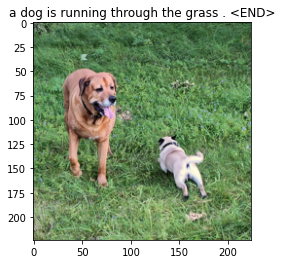

Epoch: 2 loss: 2.90689


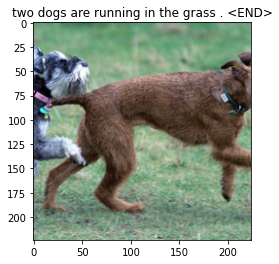

KeyboardInterrupt: 

In [24]:
# Training

num_epochs = 10
print_every = 100

for epoch in range(1,num_epochs+1):   
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)
                
            model.train()
        
    #save the latest model
    model_saver.save(model.state_dict(), train_loss=loss.item())

In [22]:
model_saver.train_loss

[3.6660208702087402, 3.196951389312744, 3.447739839553833]